# Clustering solutions using NMF #

In [1]:
# Input
from db import PythonProblems
import io

# Helpers
import numpy as np
from collections import Counter
from tqdm import tqdm
import random

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Learning
from sklearn.decomposition import NMF

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import show, output_notebook
from bokeh.plotting import figure

### Connecting to database

In [2]:
db = PythonProblems('python.sqlite')

In [3]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
cursor = db.conn.cursor()
docs = []
errors = []

# lendo os dados
cursor.execute("""
SELECT * FROM solution;
""")


for idx, linha in enumerate(cursor.fetchall()):
    file = io.StringIO(linha[1])
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (idx+1))
        
    docs.append(' '.join(doc))

print("Got %d documents" %(idx+1))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Got 758 documents
Success in parsing all documents! You may go on!


### Preprocessing solutions into bag of words ###

In [4]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
#vectorizer = CountVectorizer(analyzer = "word",   \
vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             #max_features = 26d,
                             binary=False,
                             min_df=2
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
#train_data_features = train_data_features.toarray()

# Cálculo do NMF #

### Cálculo dos modelos e da métrica *perplexity* ###

In [5]:
num_topics = list(range(2, 100))

In [6]:
output_notebook()

hover = HoverTool(tooltips=[
    ("Model", "$x{0}"),
    ("Reconstruction Error", "$y"),
])


models = {}
x_values = []
y_values = []

for k in tqdm(num_topics):
    # Build a NMF Model
    model = NMF(n_components=k, init="nndsvda", max_iter=1000, l1_ratio=0, alpha=1)
    document_topic = model.fit_transform(train_data_features)
    models[k] = {
      'model': model,
      'topic_word': model.components_,
      'document_topic': document_topic,
      'reconstruction': model.reconstruction_err_
    }

    x_values.append(k)
    y_values.append(models[k]["reconstruction"])

source = {'x_values': x_values, 'y_values': y_values}

opts = dict(plot_width=900, plot_height=500, min_border=0, title="Reconstruction Error")
plot = figure(**opts)
plot.add_tools(hover)

l = plot.line(x='x_values', y='y_values', color="#2222aa", line_width=2, source=source)
c = plot.circle(x='x_values', y='y_values', color="#2222aa", fill_color="white", size=8, source=source)
h = show(plot, notebook_handle=True)

Loading BokehJS ...

100%|██████████| 98/98 [00:50<00:00,  1.59s/it]


### Verificando em * random sample solutions* ###

In [14]:
# Escolhido tópico k
k = 12
lda_model = models[k]['model']
document_topic = models[k]['document_topic']
topic_word = models[k]['topic_word']

In [15]:
# Verificando 5 soluções de maneira aleatória
N = 5

cursor.execute("""
SELECT * FROM solution;
""")

solutions = list(cursor.fetchall())
random.shuffle(list(range(len(solutions))))

for i in range(N):
    text = solutions[i][1]
    x = lda_model.transform(vectorizer.transform([text]))[0]
    print(text)
    #print(x)
    print("Belong to topics with probabilities:")
    topics = np.argsort(x)[:-6:-1]
    probs = x[topics]
    print("t: %s" %(topics+1))
    print("P(t|d): %s" %probs)

    print('\n')

name = input("What is your name: ")
age = int(input("How old are you: "))
year = str((2014 - age)+100)
print(name + " will be 100 years old in the year " + year)

Belong to topics with probabilities:
t: [ 7  5  2 12 11]
P(t|d): [0.09039742 0.04329776 0.01487857 0.         0.        ]


num = input("Enter a number: ")
mod = num % 2
if mod > 0:
    print("You picked an odd number.")
else:
    print("You picked an even number.")
Belong to topics with probabilities:
t: [4 7 6 3 1]
P(t|d): [0.179813   0.05296557 0.0490166  0.01630528 0.01591886]


num = int(input("give me a number to check: "))
check = int(input("give me a number to divide by: "))

if num % 4 == 0:
    print(num, "is a multiple of 4")
elif num % 2 == 0:
    print(num, "is an even number")
else:
    print(num, "is an odd number")

if num % check == 0:
    print(num, "divides evenly by", check)
else:
    print(num, "does not divide evenly by", check)

Belong to topics with probabilities:
t: [4 7 6 1 3]
P(t|d): [0.33891751 0.0

#### Verificando distribuição de documentos por tópico ####

In [16]:
row_sums = document_topic.sum(axis=1)
document_topic_norm = document_topic / row_sums[:, np.newaxis]
document_topic_norm.shape

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(758, 12)

Considerando somente pertinência máxima

In [17]:
Counter(np.argmax(document_topic, axis=1))

Counter({0: 170,
         1: 123,
         2: 42,
         3: 35,
         4: 52,
         5: 123,
         6: 88,
         7: 19,
         8: 41,
         9: 26,
         10: 24,
         11: 15})

Considerando probabilidade

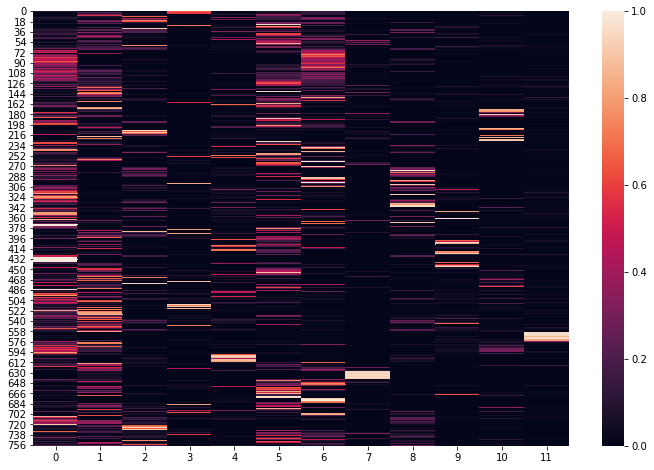

In [18]:
fig = plt.figure(figsize=(12,8))
ax = sns.heatmap(document_topic_norm)
plt.show()

In [19]:
def print_top_words(topic_word, feature_names, n_top_words):
    for topic_idx, topic in enumerate(topic_word):
        message = "Topic #%d: " % (topic_idx+1)
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [20]:
print("\nTopics in NMF model:")
feature_names = vectorizer.get_feature_names()
print_top_words(topic_word, feature_names, 10)


Topics in NMF model:
Topic #1: print format import if sys set math raw_input else input
Topic #2: in for range items append print value if dict join
Topic #3: random import sample choice range randrange color result shuffle number
Topic #4: num mod for print list in if color sum data
Topic #5: str array_num array print join result from len import word
Topic #6: return def if else print sum true elif number false
Topic #7: input int float print elif else math if month round
Topic #8: result_str column row or and range else if for in
Topic #9: os path import sys print time isfile __file__ from environ
Topic #10: str1 print count rsplit char index reverse_string join letter str2
Topic #11: li printlist list set append evennumbers lambda in for item
Topic #12: tuplex print tuple listx count index item dict false n2

